#**KLASIFIKASI CITRA NYAMUK BERBASIS CNN MENGGUNAKAN ENSEMBLE LEARNING EFFICIENTNETB0 DAN DENSENET121**

Kelompok ELDIVO
- Elisabet Simanjuntak (221402035)
- Yemima Fransiska Simanjuntak (221402041)
- Christy Eliana Simarmata (221402089)

#### Menghubungkan Colab dengan Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras import layers, models

#### Mengakses Direktori Data Train dan Test

In [ ]:
# Direktori dataset
TRAIN_DIR = '/content/drive/MyDrive/ACD/DATASET/train'
TEST_DIR  = '/content/drive/MyDrive/ACD/DATASET/test'


## IMAGE PRE-PROCESSING

In [ ]:

# Ukuran gambar dan batch
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

# Dataset training dengan split validasi 20%
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

# Dataset test
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Menampilkan nama kelas
class_names = train_ds.class_names
print("Classes:", class_names)

# Optimisasi prefetch untuk performa
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1248 files belonging to 3 classes.
Using 999 files for training.
Found 1248 files belonging to 3 classes.
Using 249 files for validation.
Found 312 files belonging to 3 classes.
Classes: ['Aedes aegypti', 'Aedes albopictus', 'Culex quinquefasciatus']


In [ ]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


#### DATA AUGMENTATION

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])


## MEMBANGUN MODEL

In [ ]:
base1 = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base1.trainable = False

inputs = layers.Input(shape=IMG_SIZE + (3,))
x1 = data_augmentation(inputs)
x1 = tf.keras.applications.efficientnet.preprocess_input(x1)
x1 = base1(x1, training=False)
x1 = layers.GlobalAveragePooling2D()(x1)
x1 = layers.Dense(128, activation="relu")(x1)
out1 = layers.Dense(len(class_names), activation="softmax", name="out1")(x1)

model1 = models.Model(inputs, out1)
model1.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
base2 = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)
base2.trainable = False

x2 = data_augmentation(inputs)
x2 = tf.keras.applications.densenet.preprocess_input(x2)
x2 = base2(x2, training=False)
x2 = layers.GlobalAveragePooling2D()(x2)
x2 = layers.Dense(128, activation="relu")(x2)
out2 = layers.Dense(len(class_names), activation="softmax", name="out2")(x2)

model2 = models.Model(inputs, out2)
model2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


### TRAINING

In [ ]:
history1 = model1.fit(train_ds, validation_data=val_ds, epochs=10)
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 277s 4s/step - accuracy: 0.6973 - loss: 0.6722 - val_accuracy: 0.8715 - val_loss: 0.3101
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 621ms/step - accuracy: 0.8620 - loss: 0.2960 - val_accuracy: 0.8956 - val_loss: 0.2604
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 607ms/step - accuracy: 0.9226 - loss: 0.2089 - val_accuracy: 0.8795 - val_loss: 0.2734
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 554ms/step - accuracy: 0.9288 - loss: 0.1731 - val_accuracy: 0.9237 - val_loss: 0.1930
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 646ms/step - accuracy: 0.9542 - loss: 0.1551 - val_accuracy: 0.9277 - val_loss: 0.2097
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 557ms/step - accuracy: 0.9496 - loss: 0.1430 - val_accuracy: 0.9277 - val_loss: 0.1647
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 615ms/step - accuracy: 0.9692 - loss: 0.1026 - val_accuracy: 0.9598 - val_loss: 0.1793
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 607ms/step - accuracy: 0.9675 - loss: 0.0903 - val_accura

### ENSEMBLE

In [ ]:
import numpy as np

def ensemble_predict(batch):
    p1 = model1.predict(batch)
    p2 = model2.predict(batch)
    final = (p1 + p2) / 2
    return final


### CONFUSION MATRIX

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = ensemble_predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/s

### GRAFIK LOSS DAN ACCURACY

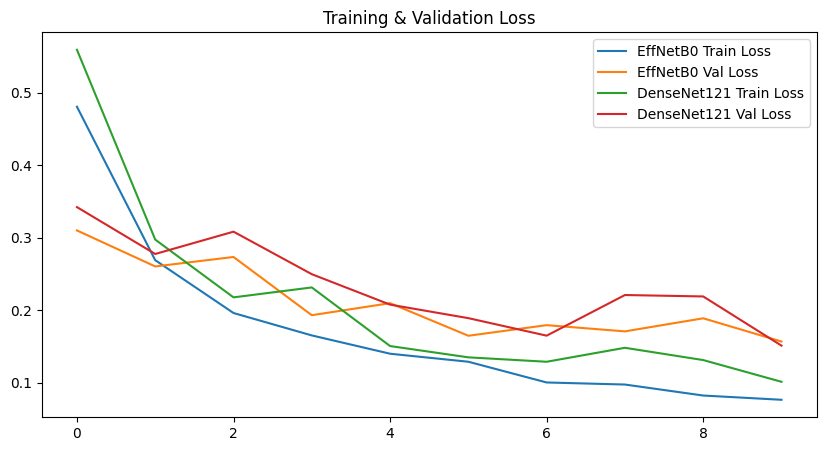

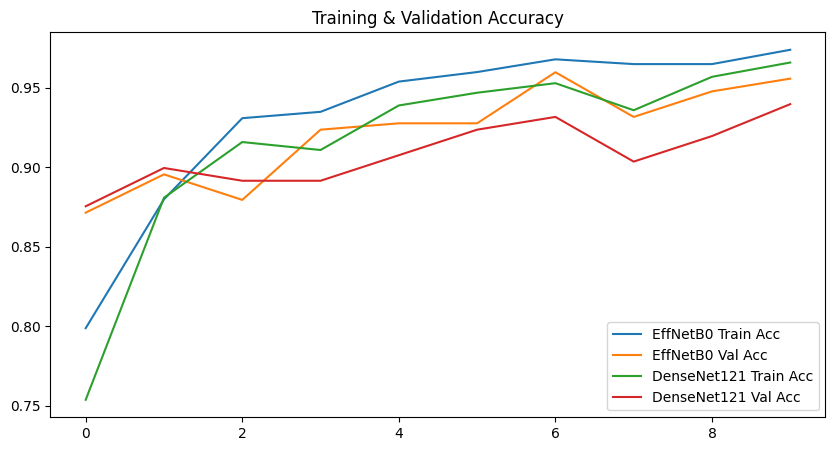

In [ ]:
import matplotlib.pyplot as plt

# -------- Loss --------
plt.figure(figsize=(10,5))
plt.plot(history1.history['loss'], label='EffNetB0 Train Loss')
plt.plot(history1.history['val_loss'], label='EffNetB0 Val Loss')
plt.plot(history2.history['loss'], label='DenseNet121 Train Loss')
plt.plot(history2.history['val_loss'], label='DenseNet121 Val Loss')
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# -------- Accuracy --------
plt.figure(figsize=(10,5))
plt.plot(history1.history['accuracy'], label='EffNetB0 Train Acc')
plt.plot(history1.history['val_accuracy'], label='EffNetB0 Val Acc')
plt.plot(history2.history['accuracy'], label='DenseNet121 Train Acc')
plt.plot(history2.history['val_accuracy'], label='DenseNet121 Val Acc')
plt.title("Training & Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt
import numpy as np

### HASIL PREDIKSI

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from PIL import UnidentifiedImageError

TEST_DIR = '/content/drive/MyDrive/ACD/DATASET/test'
IMG_SIZE = (224, 224)

results = []
valid_ext = ('.jpg', '.jpeg', '.png')

for true_class in os.listdir(TEST_DIR):
    class_dir = os.path.join(TEST_DIR, true_class)

    if not os.path.isdir(class_dir):
        continue

    for fname in os.listdir(class_dir):
        if not fname.lower().endswith(valid_ext):
            continue

        img_path = os.path.join(class_dir, fname)

        try:
            # load image
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img)

            # preprocess
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)

            # ensemble prediction
            pred = ensemble_predict(img_array)[0]
            pred_class = class_names[np.argmax(pred)]

            row = {
                "Filename": fname,
                "True Class": true_class,
                "Predicted Class": pred_class
            }

            for i, cname in enumerate(class_names):
                row[f"Prob_{cname} (%)"] = np.round(pred[i] * 100, 2)

            results.append(row)

        except UnidentifiedImageError:
            print(f"Bukan gambar: {img_path}")


df_results = pd.DataFrame(results)
print(df_results["Predicted Class"].value_counts())
print(df_results.head())

# simpan CSV
csv_path = "/content/drive/MyDrive/ACD/ensemble_test_predictions.csv"
df_results.to_csv(csv_path, index=False)

print("Hasil disimpan ke:")
print(csv_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
